In [428]:
import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import lmfit

loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Measurements\Calibration\NO2 pH\data.hdf5'
image_loc = r'E:\OneDrive - TU Eindhoven\Master thesis\Plots\Calibration\NO2 pH'
dependent = 'pH' 
variable_name = 'pH'
variable_factor = 1
wavelength_range = [180, 400]
r2_values = [0.99, 1]
wavelength_plot_every = 5
plot_number = 2
baseline_correction = [370, 390]

In [429]:
if not os.path.exists(image_loc):
    os.makedirs(image_loc)

def save_loc(loc):
    return os.path.join(image_loc, loc)

In [430]:
with h5py.File(loc, 'r') as file:
    # dark = file.attrs['dark'][:]
    # reference = file.attrs['reference'][:]
    wavelength = file.attrs['wavelength'][:]
    absorbance = []
    variable = []
    number = []
    for key in file.keys():
        absorbance.append(file[key][:])
        variable.append(file[key].attrs[dependent])
        number.append(int(key.split('_')[1].split('.')[0]))

absorbance = np.array(absorbance)
# dark = np.array(dark)
# reference = np.array(reference)
wavelength = np.array(wavelength)
variable = np.array(variable)
number = np.array(number)
# absorbance = -np.log10((measurements-dark) / (reference-dark))
mask = (wavelength_range[0] < wavelength) & (wavelength < wavelength_range[1])

absorbance_m_uncorr = absorbance[:, mask]
wavelength_m = wavelength[mask]
# dark_m = dark[mask]
# reference_m = reference[mask]

if baseline_correction is not None:
    correction_mask = (baseline_correction[0] < wavelength) & (wavelength < baseline_correction[1])
    absorbance_m = absorbance_m_uncorr - np.mean(absorbance[:, correction_mask], axis=1)[:, np.newaxis]
    absorbance_m_num = absorbance_m[number == plot_number]
    absorbance_m_uncorr_num = absorbance_m_uncorr[number == plot_number]
else:
    absorbance_m = absorbance_m_uncorr
    absorbance_m_num = absorbance_m_uncorr[number == plot_number]
    absorbance_m_uncorr_num = absorbance_m_uncorr[number == plot_number]

variable_num = variable[number==plot_number]

absorbance_best_num = np.zeros((len(np.unique(variable)), len(wavelength_m)))
variable_best_num = np.zeros(len(np.unique(variable)))
for i, v in enumerate(np.unique(variable)):
    v_absorbances = absorbance_m[variable == v]
    value = []
    pair_values = []
    for pair in itertools.combinations(range(len(v_absorbances)), 2):
        # value.append(np.sum((v_absorbances[pair[0]]-v_absorbances[pair[1]])**2))
        mask = v_absorbances[0] > 0.5*np.max(v_absorbances[0])
        value.append(np.sum((v_absorbances[pair[0]][mask]-v_absorbances[pair[1]][mask])**2))
        pair_values.append(pair)
        # pair_values.append([1, 1])
    min_num = pair_values[np.argmin(value)]
    print(f'{v}, {min_num}')
    absorbance_best_num[i] = (absorbance_m[variable == v][min_num[0]]+absorbance_m[variable == v][min_num[1]])/2
    variable_best_num[i] = v

2.032, (0, 1)
2.989, (0, 1)
4.043, (0, 1)
4.875, (0, 1)
5.499, (0, 1)
6.47, (0, 1)
6.478, (0, 1)
9.408, (0, 1)


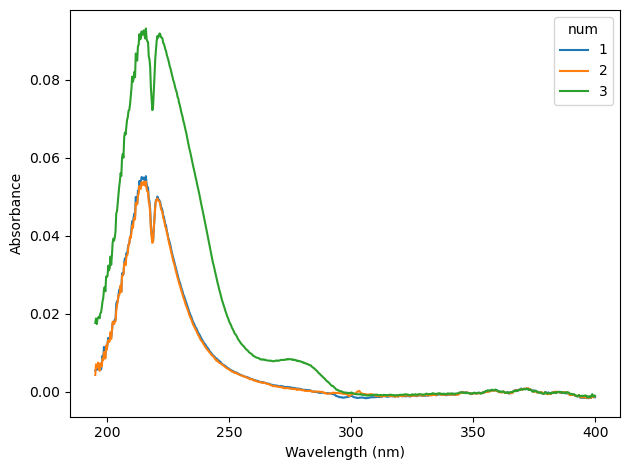

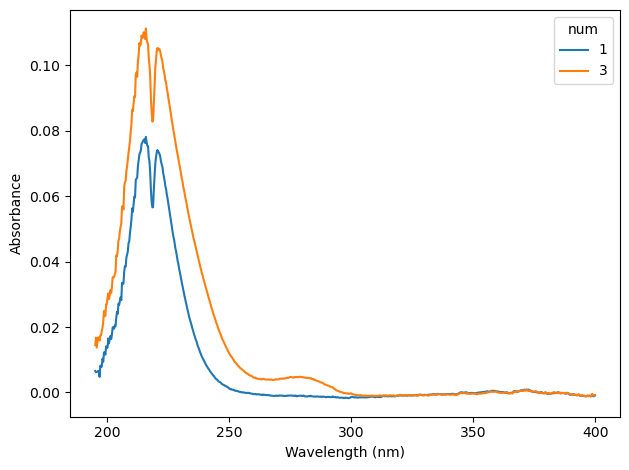

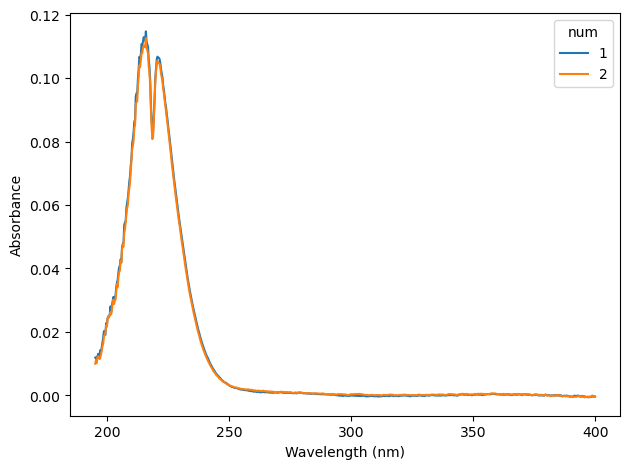

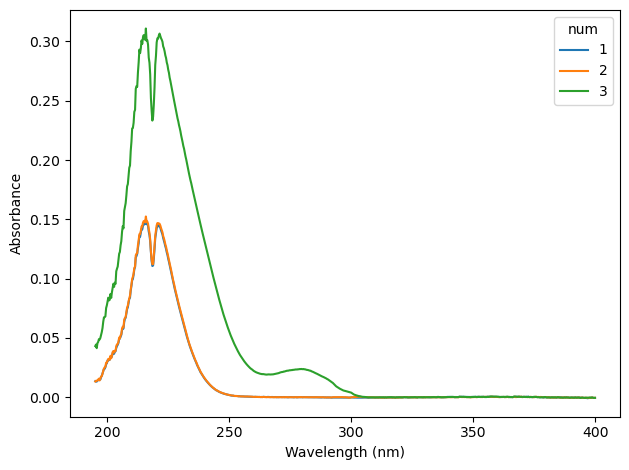

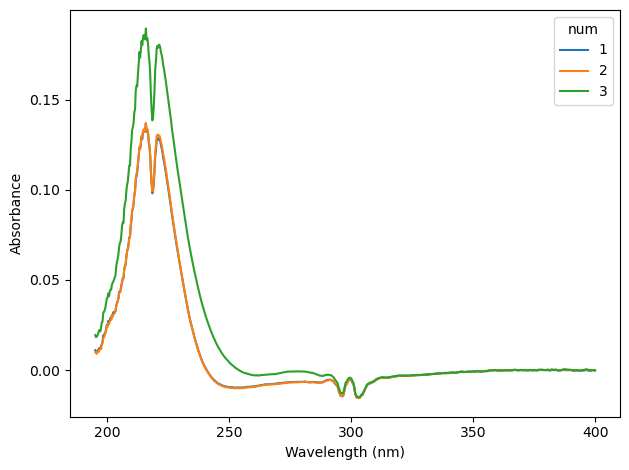

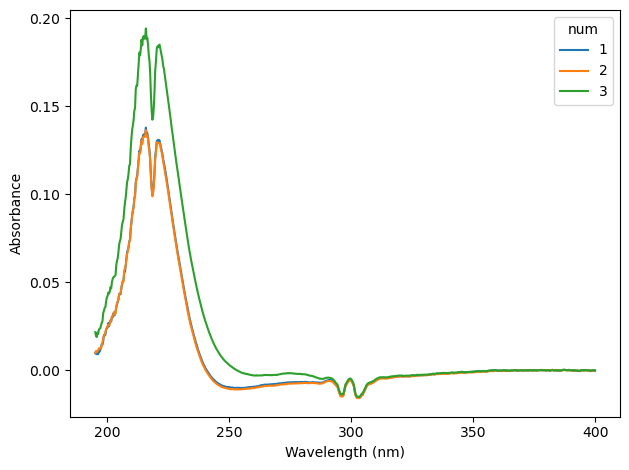

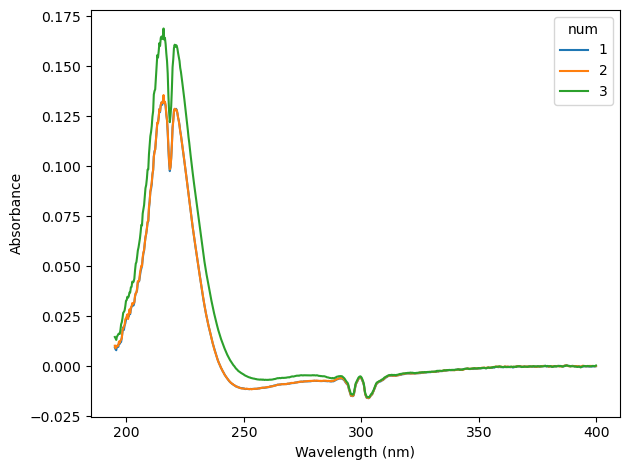

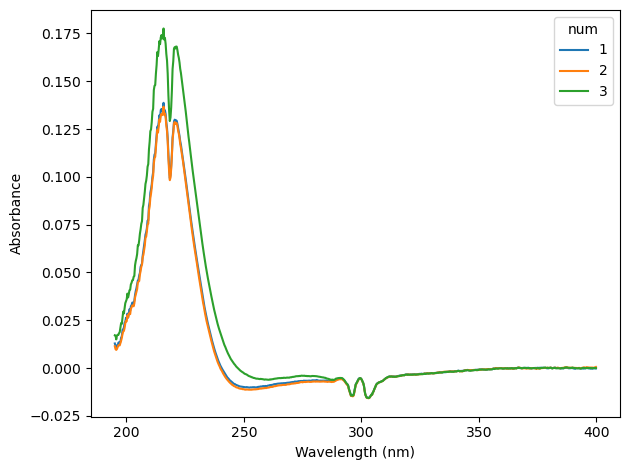

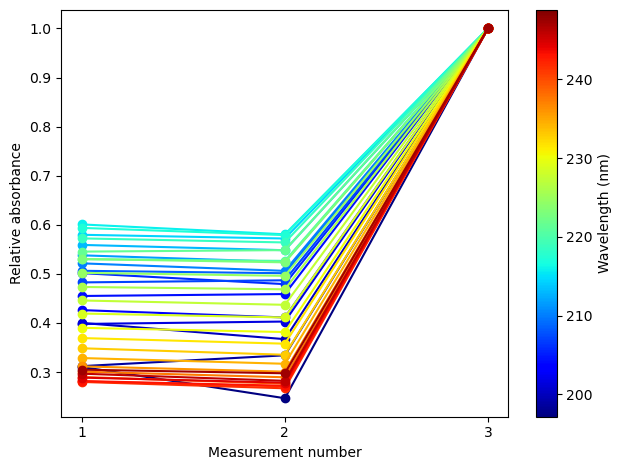

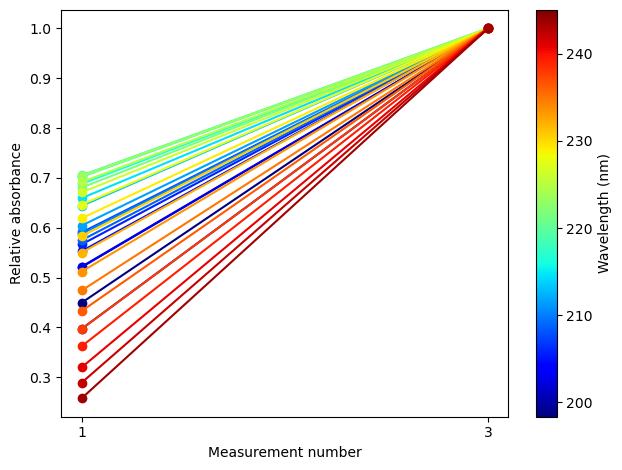

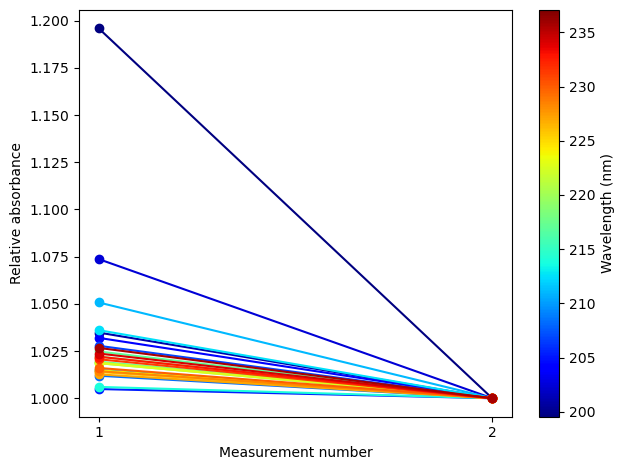

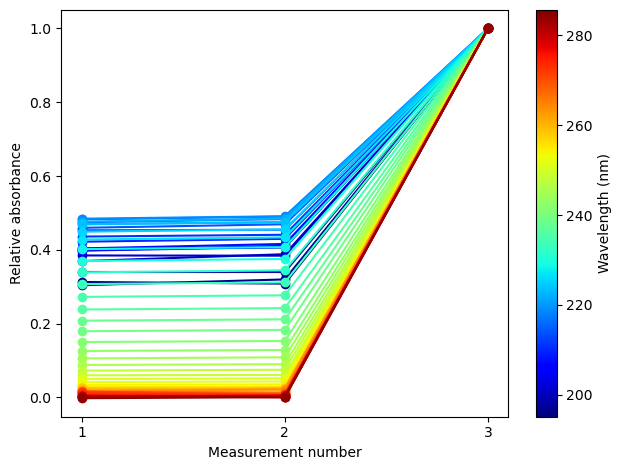

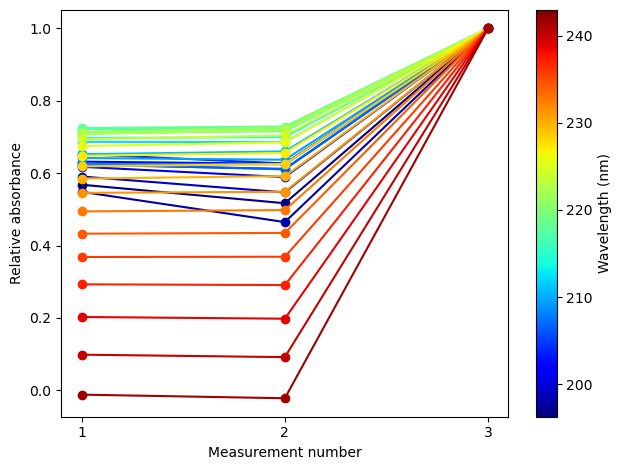

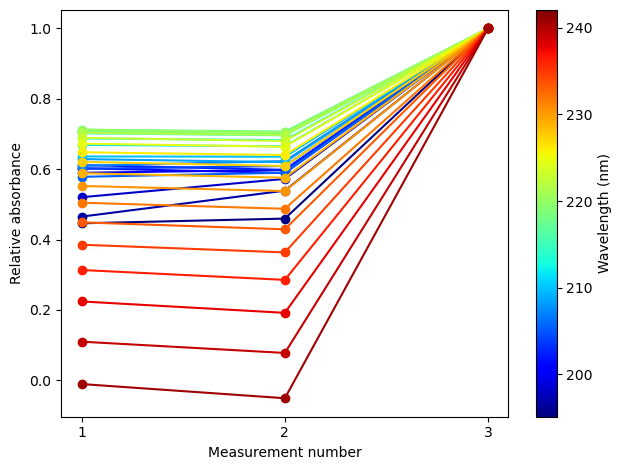

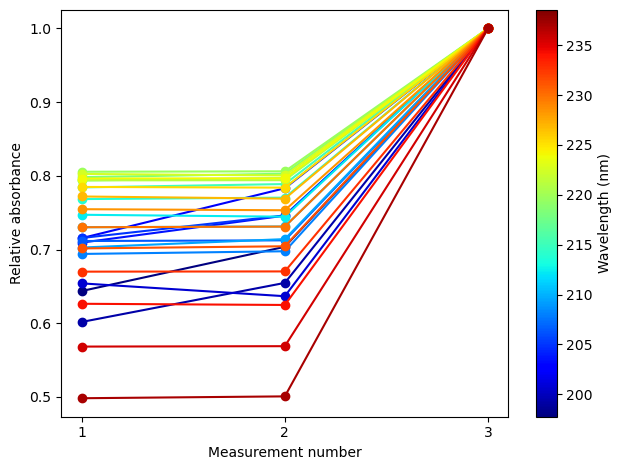

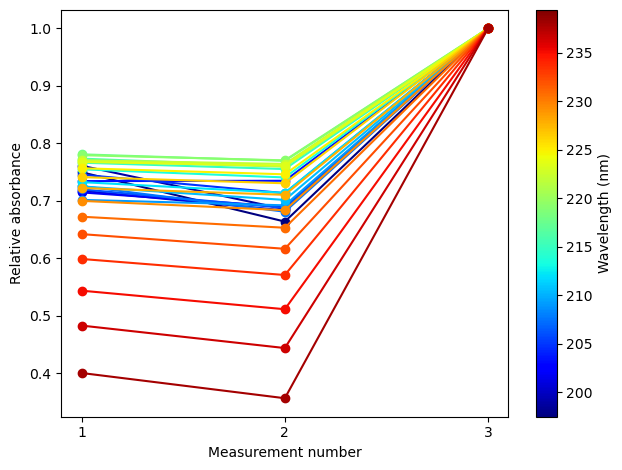

In [431]:
for value in np.unique(variable):
    plt.figure()
    for index, num in enumerate(number[variable == value]):
        plt.plot(wavelength_m, absorbance_m[(number == num) & (variable == value)].T, f'C{index}', label=num)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
    plt.legend(title='num')
    plt.tight_layout()
    plt.savefig(save_loc(f'absorbance vs wavelength {value} {variable_name}.png'))
    plt.show()

cmap = plt.get_cmap('jet')
for value in np.unique(variable):
    plt.figure()
    wav_abs_mask = absorbance_m[(variable == value)][-1, :] > 0.02
    for index, wav in enumerate(wavelength_m[wav_abs_mask][::wavelength_plot_every]):
        vals = absorbance_m[(variable == value)].T[::wavelength_plot_every][index]
        plt.plot(number[variable == value], vals/vals[-1], 'o-', color=cmap(index/len(wavelength_m[wav_abs_mask][::wavelength_plot_every])))   
    plt.xlabel('Measurement number')
    plt.ylabel('Relative absorbance')
    plt.xticks(number[variable == value])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=wavelength_m[wav_abs_mask][0], vmax=wavelength_m[wav_abs_mask][-1]))
    plt.colorbar(sm, label='Wavelength (nm)', ax=plt.gca())
    plt.tight_layout()
    plt.savefig(save_loc(f'absorbance vs measurement number {value} {variable_name}.png'))
    plt.show()

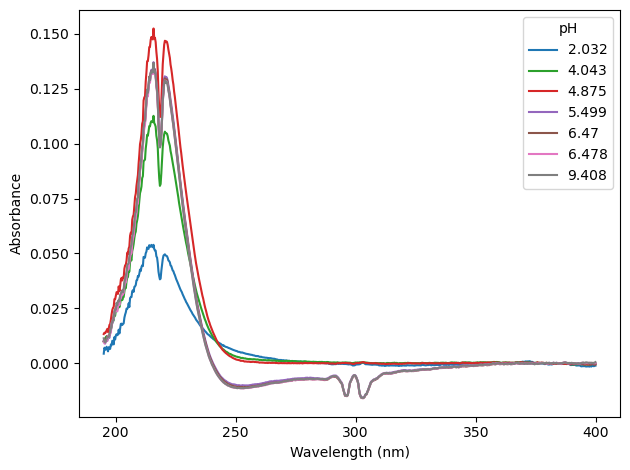

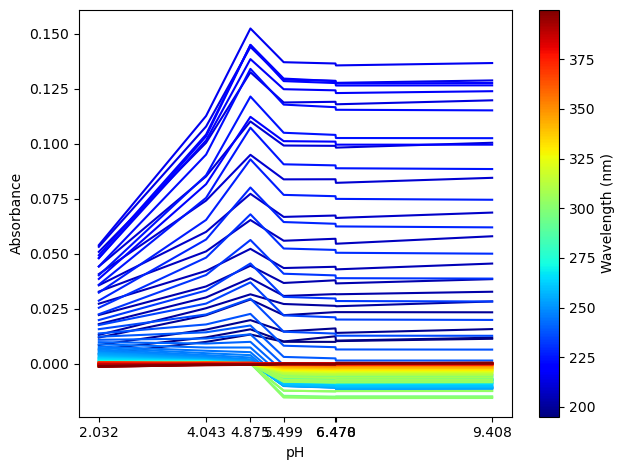

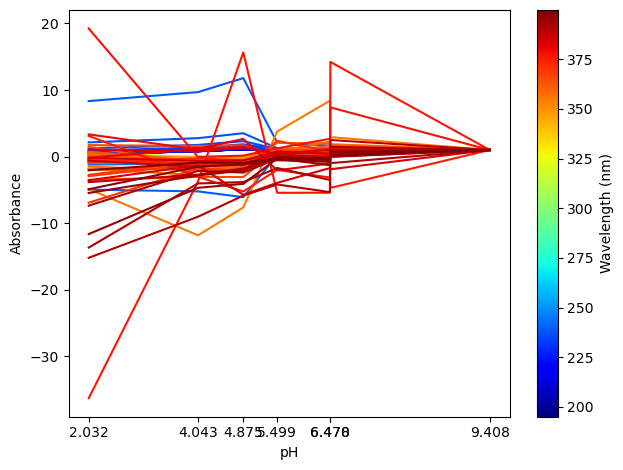

In [432]:
# plot absorbance vs variable
plt.figure()
for index, var in enumerate(np.unique(variable)):
    plt.plot(wavelength_m, absorbance_m[(number == plot_number) & (variable == var)].T, f'C{index}', label=variable_factor * var)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance')
plt.legend(title=variable_name)
plt.tight_layout()
plt.savefig(save_loc(f'absorbance vs wavelength.png'))
plt.show()

cmap = plt.get_cmap('jet')
plt.figure()
for index, wav in enumerate(wavelength_m[::wavelength_plot_every]):
    plt.plot(variable_factor * variable_num, absorbance_m_num.T[::wavelength_plot_every][index], color=cmap(index / len(wavelength_m[::wavelength_plot_every])))
plt.xlabel(variable_name)
plt.ylabel('Absorbance')
plt.xticks(variable_factor*variable_num)
# make a cmap for the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=wavelength_m[0], vmax=wavelength_m[-1]))
plt.colorbar(sm, label='Wavelength (nm)', ax=plt.gca())
plt.tight_layout()
plt.savefig(save_loc(f'absorbance vs {variable_name}.png'))
plt.show()

cmap = plt.get_cmap('jet')
plt.figure()
for index, wav in enumerate(wavelength_m[::wavelength_plot_every]):
    vals = absorbance_m_num.T[::wavelength_plot_every][index]
    plt.plot(variable_factor*variable_num, vals/vals[-1], color=cmap(index/len(wavelength_m[::wavelength_plot_every])))
plt.xlabel(variable_name)
plt.ylabel('Absorbance')
plt.xticks(variable_factor*variable_num)
# make a cmap for the plot
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=wavelength_m[0], vmax=wavelength_m[-1]))
plt.colorbar(sm, label='Wavelength (nm)', ax=plt.gca())
plt.tight_layout()
plt.savefig(save_loc(f'absorbance vs {variable_name} relative.png'))
plt.show()

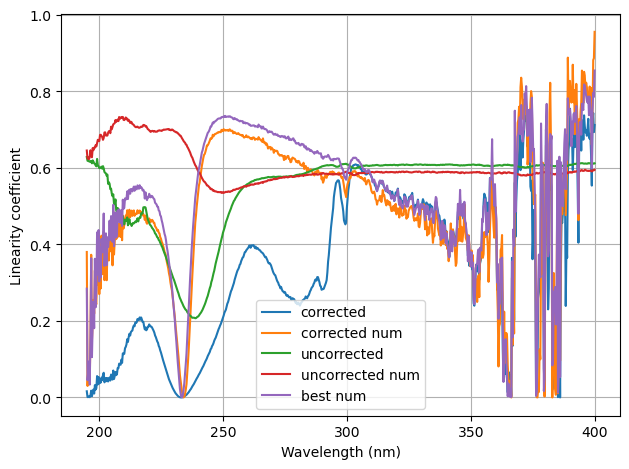

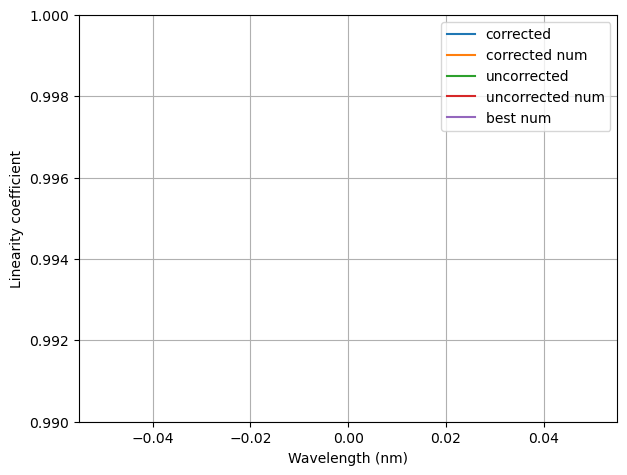

In [433]:
# pearson r for each wavelength
if baseline_correction is not None:
    linearity = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        linearity[i] = scipy.stats.pearsonr(variable, absorbance_m[:, i])[0]
    
    linearity_corrected_num = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        linearity_corrected_num[i] = scipy.stats.pearsonr(variable_num, absorbance_m_num[:, i])[0]

linearity_uncorrected = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    linearity_uncorrected[i] = scipy.stats.pearsonr(variable, absorbance_m_uncorr[:, i])[0]

linearity_uncorrected_num = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    linearity_uncorrected_num[i] = scipy.stats.pearsonr(variable_num, absorbance_m_uncorr_num[:, i])[0]

linearity_best_num = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    linearity_best_num[i] = scipy.stats.pearsonr(variable_best_num, absorbance_best_num[:, i])[0]

plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, linearity**2, label='corrected')
    plt.plot(wavelength_m, linearity_corrected_num**2, label='corrected num')
plt.plot(wavelength_m, linearity_uncorrected**2, label='uncorrected')
plt.plot(wavelength_m, linearity_uncorrected_num**2, label='uncorrected num')
plt.plot(wavelength_m, linearity_best_num**2, label='best num')
plt.xlabel('Wavelength (nm)')  
plt.ylabel('Linearity coefficient')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'linearity vs wavelength method comparison.png'))
plt.show()

r2_mask = ((r2_values[0] < linearity_uncorrected**2) & (linearity_uncorrected**2 < r2_values[1])) | ((r2_values[0] < linearity_uncorrected_num**2) & (linearity_uncorrected_num**2 < r2_values[1])) | ((r2_values[0] < linearity_best_num**2) & (linearity_best_num**2 < r2_values[1]))
if baseline_correction is not None:
    r2_mask = r2_mask | ((r2_values[0] < linearity**2) & (linearity**2 < r2_values[1])) | ((r2_values[0] < linearity_corrected_num**2) & (linearity_corrected_num**2 < r2_values[1]))

wavs = wavelength_m[r2_mask]
dw = np.diff(wavs)
index = np.nonzero(dw > 10)[0]
if len(index) > 0:
    r2_mask[index[0]+1:] = False   
# r2_mask[index+1:] = False

plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m[r2_mask], linearity[r2_mask]**2, label='corrected')
    plt.plot(wavelength_m[r2_mask], linearity_corrected_num[r2_mask]**2, label='corrected num')
plt.plot(wavelength_m[r2_mask], linearity_uncorrected[r2_mask]**2, label='uncorrected')
plt.plot(wavelength_m[r2_mask], linearity_uncorrected_num[r2_mask]**2, label='uncorrected num')
plt.plot(wavelength_m[r2_mask], linearity_best_num[r2_mask]**2, label='best num')
plt.xlabel('Wavelength (nm)')  
plt.ylabel('Linearity coefficient')
plt.grid()
plt.legend()
plt.tight_layout()
plt.ylim(*r2_values)
plt.savefig(save_loc(f'linearity vs wavelength zoomed method comparison.png'))
plt.show()

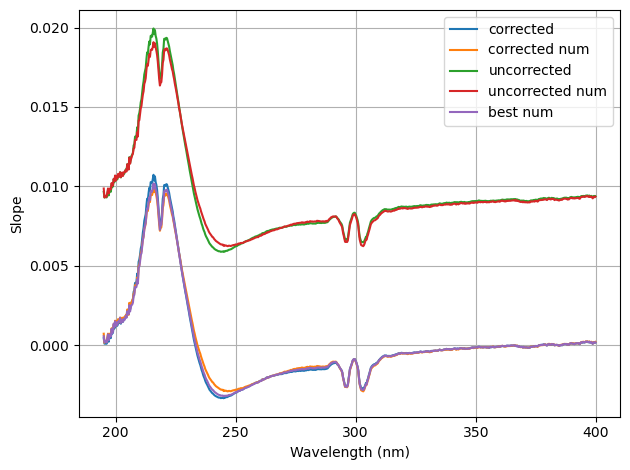

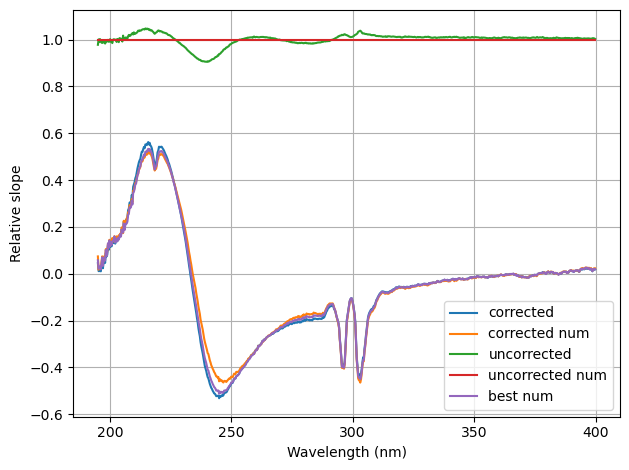

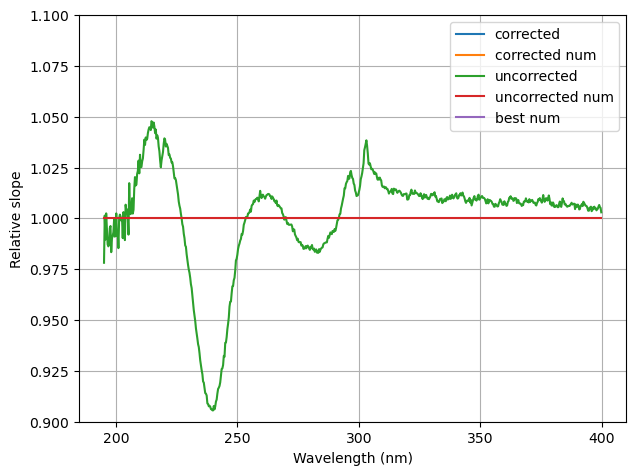

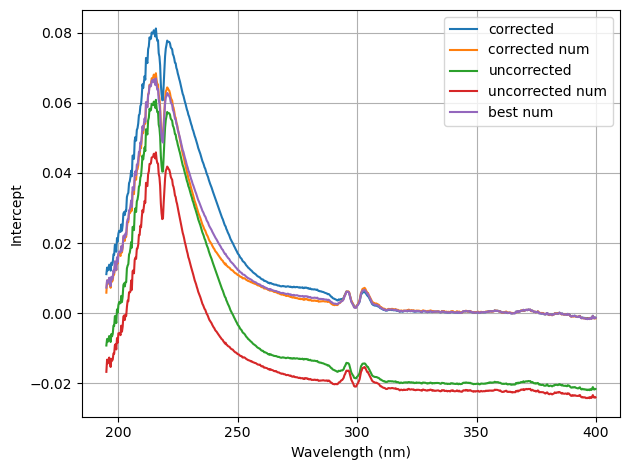

In [434]:
# linear fit for each wavelength
if baseline_correction is not None:
    slope = np.zeros(len(wavelength_m))
    intercept = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        slope[i], intercept[i] = np.polyfit(variable, absorbance_m[:, i], 1)
    
    slope_corrected_num = np.zeros(len(wavelength_m))
    intercept_corrected_num = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        slope_corrected_num[i], intercept_corrected_num[i] = np.polyfit(variable_num, absorbance_m_num[:, i], 1)

slope_uncorrected = np.zeros(len(wavelength_m))
intercept_uncorrected = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    slope_uncorrected[i], intercept_uncorrected[i] = np.polyfit(variable, absorbance_m_uncorr[:, i], 1)

slope_uncorrected_num = np.zeros(len(wavelength_m))
intercept_uncorrected_num = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    slope_uncorrected_num[i], intercept_uncorrected_num[i] = np.polyfit(variable_num, absorbance_m_uncorr_num[:, i], 1)

slope_best_num = np.zeros(len(wavelength_m))
intercept_best_num = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    slope_best_num[i], intercept_best_num[i] = np.polyfit(variable_best_num, absorbance_best_num[:, i], 1)

plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, slope, label='corrected')
    plt.plot(wavelength_m, slope_corrected_num, label='corrected num')
plt.plot(wavelength_m, slope_uncorrected, label='uncorrected')
plt.plot(wavelength_m, slope_uncorrected_num, label='uncorrected num')
plt.plot(wavelength_m, slope_best_num, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Slope')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'slope vs wavelength method comparison.png'))
plt.show()

# plot relative slope
plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, slope/slope_uncorrected_num, label='corrected')
    plt.plot(wavelength_m, slope_corrected_num/slope_uncorrected_num, label='corrected num')
plt.plot(wavelength_m, slope_uncorrected/slope_uncorrected_num, label='uncorrected')
plt.plot(wavelength_m, slope_uncorrected_num/slope_uncorrected_num, label='uncorrected num')
plt.plot(wavelength_m, slope_best_num/slope_uncorrected_num, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative slope')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'slope vs wavelength relative method comparison.png'))
plt.show()

# plot relative slope
plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, slope/slope_uncorrected_num, label='corrected')
    plt.plot(wavelength_m, slope_corrected_num/slope_uncorrected_num, label='corrected num')
plt.plot(wavelength_m, slope_uncorrected/slope_uncorrected_num, label='uncorrected')
plt.plot(wavelength_m, slope_uncorrected_num/slope_uncorrected_num, label='uncorrected num')
plt.plot(wavelength_m, slope_best_num/slope_uncorrected_num, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative slope')
plt.legend()
plt.grid()
plt.tight_layout()
plt.ylim(0.9, 1.1)
plt.savefig(save_loc(f'slope vs wavelength relative method comparison zoom.png'))
plt.show()

plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, intercept, label='corrected')
    plt.plot(wavelength_m, intercept_corrected_num, label='corrected num')
plt.plot(wavelength_m, intercept_uncorrected, label='uncorrected')
plt.plot(wavelength_m, intercept_uncorrected_num, label='uncorrected num')
plt.plot(wavelength_m, intercept_best_num, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intercept')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'intercept vs wavelength method comparison.png'))
plt.show()

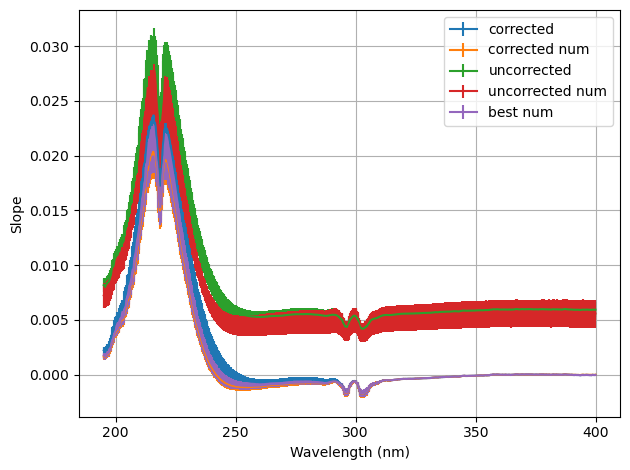

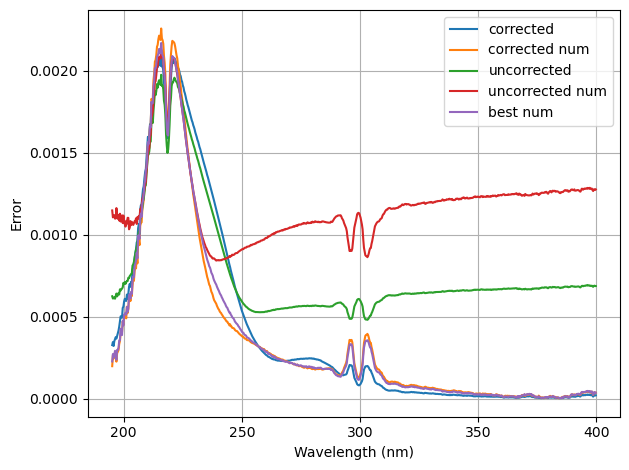

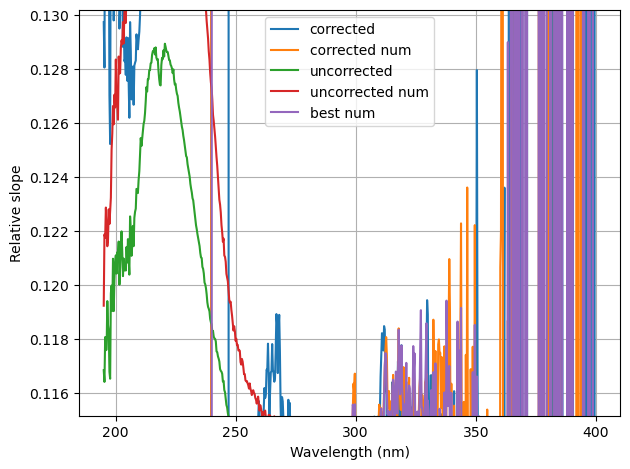

In [435]:
# linear fit for each wavelength
lin_model = lmfit.models.LinearModel()
params = lin_model.make_params()
params['intercept'].value = 0
params['intercept'].vary = False

if baseline_correction is not None:
    slope = np.zeros(len(wavelength_m))
    slope_std = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        result = lin_model.fit(absorbance_m[:, i], params, x=variable)
        slope[i] = result.params['slope'].value
        slope_std[i] = result.params['slope'].stderr
    
    slope_corrected_num = np.zeros(len(wavelength_m))
    slope_corrected_num_std = np.zeros(len(wavelength_m))
    for i in range(len(wavelength_m)):
        result = lin_model.fit(absorbance_m_num[:, i], params, x=variable_num)
        slope_corrected_num[i] = result.params['slope'].value
        slope_corrected_num_std[i] = result.params['slope'].stderr

slope_uncorrected = np.zeros(len(wavelength_m))
slope_uncorrected_std = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    result = lin_model.fit(absorbance_m_uncorr[:, i], params, x=variable)
    slope_uncorrected[i] = result.params['slope'].value
    slope_uncorrected_std[i] = result.params['slope'].stderr

slope_uncorrected_num = np.zeros(len(wavelength_m))
slope_uncorrected_num_std = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    result = lin_model.fit(absorbance_m_uncorr_num[:, i], params, x=variable_num)
    slope_uncorrected_num[i] = result.params['slope'].value
    slope_uncorrected_num_std[i] = result.params['slope'].stderr

slope_best_num = np.zeros(len(wavelength_m))
slope_best_num_std = np.zeros(len(wavelength_m))
for i in range(len(wavelength_m)):
    result = lin_model.fit(absorbance_best_num[:, i], params, x=variable_best_num)
    slope_best_num[i] = result.params['slope'].value
    slope_best_num_std[i] = result.params['slope'].stderr


plt.figure()
if baseline_correction is not None:
    plt.errorbar(wavelength_m, slope, yerr=slope_std, label='corrected')
    plt.errorbar(wavelength_m, slope_corrected_num, yerr=slope_corrected_num_std, label='corrected num')
plt.errorbar(wavelength_m, slope_uncorrected, yerr=slope_uncorrected_std, label='uncorrected')
plt.errorbar(wavelength_m, slope_uncorrected_num, yerr=slope_uncorrected_num_std, label='uncorrected num')
plt.errorbar(wavelength_m, slope_best_num, yerr=slope_best_num_std, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Slope')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'slope vs wavelength method comparison err.png'))
plt.show()

# plot wavelength vs error
plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, slope_std, label='corrected')
    plt.plot(wavelength_m, slope_corrected_num_std, label='corrected num')
plt.plot(wavelength_m, slope_uncorrected_std, label='uncorrected')
plt.plot(wavelength_m, slope_uncorrected_num_std, label='uncorrected num')
plt.plot(wavelength_m, slope_best_num_std, label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Error')
plt.legend()
plt.grid()
plt.tight_layout()
# plt.savefig(save_loc(f'slope vs wavelength relative error method comparison.png'))
plt.show()

# plot relative slope
mask = absorbance_m[-1] > 0.05*np.max(absorbance_m_uncorr[-1])
y_min, y_max = np.min(slope_uncorrected[mask]/absorbance_m_uncorr[-1][mask]), np.max(slope_uncorrected[mask]/absorbance_m_uncorr[-1][mask])
dy = y_max-y_min
y_min -= 0.1*dy
y_max += 0.1*dy
plt.figure()
if baseline_correction is not None:
    plt.plot(wavelength_m, slope/absorbance_m[-1], label='corrected')
    plt.plot(wavelength_m, slope_corrected_num/absorbance_m_num[-1], label='corrected num')
plt.plot(wavelength_m, slope_uncorrected/absorbance_m_uncorr[-1], label='uncorrected')
plt.plot(wavelength_m, slope_uncorrected_num/absorbance_m_uncorr_num[-1], label='uncorrected num')
plt.plot(wavelength_m, slope_best_num/absorbance_best_num[-1], label='best num')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Relative slope')
plt.legend()
plt.grid()
plt.ylim(y_min, y_max)
plt.tight_layout()
# plt.savefig(save_loc(f'slope vs wavelength relative method comparison.png'))
plt.show()


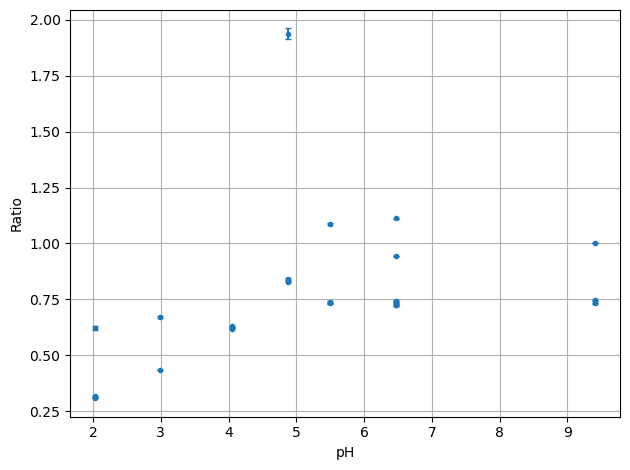

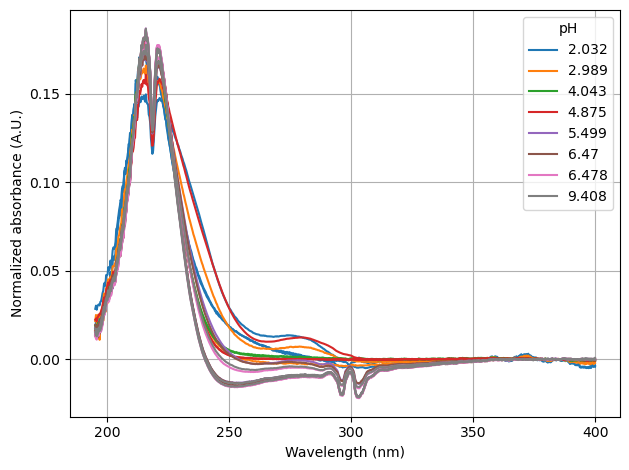

In [436]:
def residual(pars, x, reference):
    a =pars['a'].value
    return x - a * reference

params = lmfit.Parameters()
params.add('a', value=1, vary=True)
ratio = []
ratio_std = []
for i in absorbance_m:
    result = lmfit.minimize(residual, params, args=(i,), kws={'reference': absorbance_m[-1]})
    ratio.append(result.params['a'].value)
    ratio_std.append(result.params['a'].stderr)
ratio = np.array(ratio)
ratio_std = np.array(ratio_std)

plt.figure()
plt.errorbar(variable, ratio, yerr=ratio_std, capsize=2, fmt='.')
plt.xlabel(variable_name)
plt.ylabel('Ratio')
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'Relative intensity vs {variable_name}.png'))
plt.show()

lines, labels = [], []
plt.figure()
for index, var in enumerate(np.unique(variable)):
    plt.plot(wavelength_m, absorbance_m[variable==var].T/ratio[variable==var], f'C{index}', label=var)
    lines.append(plt.Line2D([0], [0], color=f'C{index}'))
    labels.append(f'{var}')
# plt.plot(wavelength_m, absorbance_m.T/ratio, label=variable)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized absorbance (A.U.)')
plt.legend(lines, labels, title=variable_name)
plt.grid()
plt.tight_layout()
plt.savefig(save_loc(f'Normalized absorbance vs wavelength.png'))
plt.show()



# Fit report
corrected: 0.132 ± 0.001
corrected num: 0.152 ± 0.001
uncorrected: 0.122 ± 0.000
uncorrected num: 0.130 ± 0.001
best num: 0.154 ± 0.001


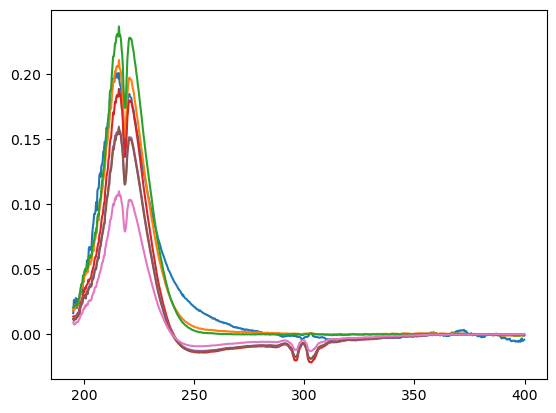

In [437]:
def residual(pars, x, concentration):
    a =pars['a'].value
    return x - a * concentration*x[-1]

params = lmfit.Parameters()
params.add('a', value=1, vary=True)

if baseline_correction is not None:
    result = lmfit.minimize(residual, params, args=(absorbance_m,), kws={'concentration': variable[:, np.newaxis]}) 
    result_num = lmfit.minimize(residual, params, args=(absorbance_m_num,), kws={'concentration': variable_num[:, np.newaxis]})
result_uncorr = lmfit.minimize(residual, params, args=(absorbance_m_uncorr,), kws={'concentration': variable[:, np.newaxis]})
result_uncorr_num = lmfit.minimize(residual, params, args=(absorbance_m_uncorr_num,), kws={'concentration': variable_num[:, np.newaxis]})
result_best_num = lmfit.minimize(residual, params, args=(absorbance_best_num,), kws={'concentration': variable_best_num[:, np.newaxis]})

print(f"""
# Fit report
corrected: {result.params['a'].value:.3f} ± {result.params['a'].stderr:.3f}
corrected num: {result_num.params['a'].value:.3f} ± {result_num.params['a'].stderr:.3f}
uncorrected: {result_uncorr.params['a'].value:.3f} ± {result_uncorr.params['a'].stderr:.3f}
uncorrected num: {result_uncorr_num.params['a'].value:.3f} ± {result_uncorr_num.params['a'].stderr:.3f}
best num: {result_best_num.params['a'].value:.3f} ± {result_best_num.params['a'].stderr:.3f}""")


plt.figure()
plt.plot(wavelength_m, (absorbance_m_num/(result.params['a'].value*variable_num[:, np.newaxis])).T)
plt.show()